# Autograd

References:

* Ryan Adams' talk: https://www.youtube.com/watch?v=sq2gPzlrM0g
* Backpropagation notes from Stanford's CS231n: http://cs231n.github.io/optimization-2/
* Autograd Github Repository (contains a tutorial and examples): https://github.com/HIPS/autograd

## Approaches for Computing Derivatives

* **Symbolic differentiation:** automatic manipulation of mathematical expressions to get derivatives
    - Takes a math expression and returns a math expression: $f(x) = x^2 \rightarrow \frac{df(x)}{dx} = 2x$
    - Used in Mathematica, Maple, Sympy, etc.
* **Numeric differentiation:** Approximating derivatives by finite differences:
$$
\frac{\partial}{\partial x_i} f(x_1, \dots, x_N) = \lim_{h \to 0} \frac{f(x_1, \dots, x_i + h, \dots, x_N) - f(x_1, \dots, x_i - h, \dots, x_N)}{2h}
$$
* **Automatic differentiation:** Takes code that computes a function and returns code that computes the derivative of that function.
    - Reverse Mode AD: A method to get exact derivatives efficiently, by storing information as you go forward that you can reuse as you go backwards
    - "The goal isn't to obtain closed-form solutions, but to be able to wirte a program that efficiently computes the derivatives." - Lecture 6 Slides (Backpropagation)
    - **Torch, Autograd**

## Reverse Mode Automatic Differentiation

In machine learning, we have functions that have large fan-in, e.g. a neural net can have millions of parameters, that all squeeze down to one scalar that tells you how well it predicts something.  cats.

### General Idea for Implementation

* Create a "tape" data structure that tracks the operations performed in computing a function
* Overload primitives to:
    - Add themselves to the tape when called
    - Compute gradients with respect to their local inputs
* _Forward pass_ computes the function, and adds operations to the tape
* _Reverse pass_ accumulates the local gradients using the chain rule
* This is efficient for graphs with large fan-in, like most loss functions in ML

## Autograd

* [Autograd](https://github.com/HIPS/autograd) is a Python package for automatic differentiation.
* To install Autograd:
                pip install autograd
* There are a lot of great [examples](https://github.com/HIPS/autograd/tree/master/examples) provided with the source code

### What can Autograd do?

From the Autograd Github repository:

* Autograd can automatically differentiate native Python and Numpy code.
* It can handle a large subset of Python's features, including loops, conditional statements (if/else), recursion and closures
* It can also compute higher-order derivatives
* It uses reverse-mode differentiation (a.k.a. backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued arguments.


## Autograd vs Tensorflow, Theano, etc.

Many deep learning packages implement automatic differentiation using small _domain-specific languages_ within Python:
    - Theano
    - Caffe
    - Vanilla Torch (as compared to Autograd for Torch)
    - Tensorflow
Most of these alternatives require you to _explicitly_ construct a computation graph; Autograd constructs a computation graph _implicitly_, by tracking the sequence of operations that have been performed during the execution of a program.


## Autograd Basic Usage

In [0]:
import autograd.numpy as np # Import thinly-wrapped numpy
from autograd import grad   # Basicallly the only function you need

In [0]:
# Define a function like normal, using Python and Numpy
def tanh(x):
    y = np.exp(-x)
    return (1.0 - y) / (1.0 + y)

# Create a *function* that computes the gradient of tanh
grad_tanh = grad(tanh)

# Evaluate the gradient at x = 1.0
print(grad_tanh(1.0))

# Compare to numeric gradient computed using finite differences
print((tanh(1.0001) - tanh(0.9999)) / 0.0002)

0.39322386648296376
0.39322386636453377


# Pytorch

Autograd doesn't support GPUs, so we cannot use autograd for training big neural networks. Pytorch is a gpu friendly framework on top of autograd.

## PyTorch: The Basics

PyTorch allows you to dynamically define computational graphs that can be computed efficently on GPUs.

Here is an example, where we work with the function

$$f(x) = x^2 + 2x + 6$$

In [0]:
import torch

In [0]:
def f(x):
    return x ** 2 + 2 * x + 6
np_x = np.array([4.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)
print(y)

tensor([30.], dtype=torch.float64, grad_fn=<AddBackward0>)


In [0]:
y.backward()
x.grad

tensor([10.], dtype=torch.float64)

In [0]:
np_x = np.array([5.0])
x = torch.from_numpy(np_x).requires_grad_(True)
y = f(x)

In [0]:
y.backward()
x.grad

tensor([12.], dtype=torch.float64)

## Pytorch vs Manual Gradients via Staged Computation

In this example, we will see how a complicated computation can be written as a composition of simpler functions, and how this provides a scalable strategy for computing gradients using the chain rule.

Say we want to write a function to compute the gradient of the *sigmoid function*:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
We can write $\sigma(x)$ as a composition of several elementary functions, as $\sigma(x) = s(c(b(a(x))))$, where:

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$

Here, we have "staged" the computation such that it contains several intermediate variables, each of which are basic expressions for which we can easily compute the local gradients.

The computation graph for this expression is shown in the figure below. 
 
![Gradient Computation Image](https://drive.google.com/uc?export=view&id=1bvdPv0MI2eM3GeobsHFsFjLrLsibuhJa)

The input to this function is $x$, and the output is represented by node $s$. We wish compute the gradient of $s$ with respect to $x$, $\frac{\partial s}{\partial x}$. In order to make use of our intermediate computations, we can use the chain rule as follows:
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$

<!--
Given a vector-to-scalar function, $\mathbb{R}^D \to \mathbb{R}$, composed of a set of primitive functions
$\mathbb{R}^M \to \mathbb{R}^N$ (for various $M$, $N$), the gradient of the composition is given by the product of the gradients of the primitive functions, according to the chain rule. But the chain rule doesn’t prescribe the order in which to multiply the gradients. From the perspective of computational complexity, the order makes all the
difference.
-->

In [0]:
def grad_sigmoid_manual(x):
    """Implements the gradient of the logistic sigmoid function 
    $\sigma(x) = 1 / (1 + e^{-x})$ using staged computation
    """
    # Forward pass, keeping track of intermediate values for use in the 
    # backward pass
    a = -x         # -x in denominator
    b = np.exp(a)  # e^{-x} in denominator
    c = 1 + b      # 1 + e^{-x} in denominator
    s = 1.0 / c    # Final result, 1.0 / (1 + e^{-x})
    
    # Backward pass
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx


def sigmoid(x):
    y = 1.0 / (1.0 + torch.exp(-x))
    return y

input_x = 2.0
x = torch.tensor(input_x).requires_grad_(True)
y = sigmoid(x)
y.backward()

# Compare the results of manual and automatic gradient functions:
print('autograd:', x.grad.item())
print('manual:', grad_sigmoid_manual(input_x))

autograd: 0.10499356687068939
manual: 0.1049935854035065


## Modularity: Implementing Custom Gradients

One thing you can do is define custom gradients for your own functions. There are several reasons you might want to do this, including:

1. **Speed:** You may know a faster way to compute the gradient for a specific function.
2. **Numerical Stability**
3. When your code depends on **external library calls**

The `@primitive` decorator wraps a function so that its gradient can be specified manually and its invocation can be recorded.

In [0]:

class MyLogSumExp(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        max_x = torch.max(input)
        ans = max_x + torch.log(torch.sum(torch.exp(input - max_x)))
        ctx.save_for_backward(input, ans)
        return ans



    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, ans = ctx.saved_tensors
        return torch.ones_like(input)*grad_output * (input - ans).exp()




In [0]:
mylogsumexp = MyLogSumExp.apply

# Now we can use logsumexp() inside a larger function that we want to differentiate.
def example_func(y, myimp):
    z = y**2
    if myimp is True:
      lse = mylogsumexp(z)
    else:
      lse = torch.logsumexp(z, dim=0)
    return lse


input_x = torch.randn(10).requires_grad_(True)
output = example_func(input_x, myimp=False)
output.backward()
print('our implementation:', input_x.grad)
input_x.grad.zero_()

output = example_func(input_x, myimp=False)
output.backward()
print('torch impelementation:', input_x.grad)



our implementation: tensor([ 5.9797e+00,  4.7883e-04,  1.6453e-05, -1.7593e-06,  5.0308e-04,
        -1.9143e-04, -1.0246e-04, -4.3527e-04,  1.1418e-04, -6.9619e-04])
torch impelementation: tensor([ 5.9797e+00,  4.7883e-04,  1.6453e-05, -1.7593e-06,  5.0308e-04,
        -1.9143e-04, -1.0246e-04, -4.3527e-04,  1.1418e-04, -6.9619e-04])


# Examples

The next three sections of the notebook show examples of using pytorch in the context of three problems:

1. **1-D linear regression**, where we try to fit a model to a function $y = wx + b$
2. **Linear regression using a polynomial feature map**, to fit a function of the form $y = w_0 + w_1 x + w_2 x^2 + \dots + w_M x^M$
3. **Nonlinear regression using a neural network**

## Linear Regression

### Review

We are given a set of data points $\{ (x_1, t_1), (x_2, t_2), \dots, (x_N, t_N) \}$, where each point $(x_i, t_i)$ consists of an *input value* $x_i$ and a *target value* $t_i$. 

The **model** we use is:
$$
y_i = wx_i + b
$$

We want each predicted value $y_i$ to be close to the ground truth value $t_i$. In linear regression, we use squared error to quantify the disagreement between $y_i$ and $t_i$. The **loss function** for a single example is:
$$
\mathcal{L}(y_i,t_i) = \frac{1}{2} (y_i - t_i)^2
$$

The **cost function** is the loss averaged over all the training examples:
$$
\mathcal{E}(w,b) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i, t_i) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left(wx_i + b - t_i \right)^2
$$

In [0]:
import numpy as np # Import wrapped NumPy from Autograd
import numpy.random as npr # For convenient access to numpy.random

import matplotlib.pyplot as plt # For plotting

%matplotlib inline

We generate a synthetic dataset $\{ (x_i, t_i) \}$ by first taking the $x_i$ to be linearly spaced in the range $[0, 10]$ and generating the corresponding value of $t_i$ using the following equation (where $w = 4$ and $b=10$):
$$
t_i = 4 x_i + 10 + \epsilon
$$

Here, $\epsilon \sim \mathcal{N}(0, 2)$ (that is, $\epsilon$ is drawn from a Gaussian distribution with mean 0 and variance 2). This introduces some random fluctuation in the data, to mimic real data that has an underlying regularity, but for which individual observations are corrupted by random noise.

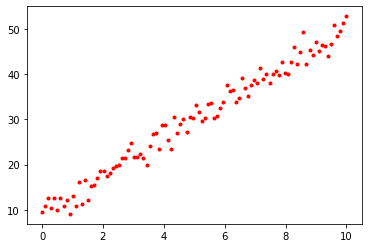

In [0]:
# In our synthetic data, we have w = 4 and b = 10
N = 100 # Number of training data points
x = np.linspace(0, 10, N)

t = 4 * x + 10 + npr.normal(0, 2, x.shape[0])
plt.plot(x, t, 'r.')

x = torch.from_numpy(x)
t = torch.from_numpy(t)

In [0]:
# Initialize random parameters

w = torch.nn.Parameter(torch.randn(1))
b = torch.nn.Parameter(torch.randn(1))


params = { 'w': w, 'b': b } # One option: aggregate parameters in a dictionary

def cost(params):
    y = params['w'] * x + params['b']
    return (1 / N) * torch.sum(0.5 * (y - t)**2)

# Find the gradient of the cost function using pytorch

num_epochs = 1000  # Number of epochs of training
alpha = 0.01       # Learning rate


for i in range(num_epochs):
    # Evaluate the gradient of the current parameters stored in params
    loss = cost(params)
    loss.backward()

    print('loss:', loss.item())

    # Update parameters w and b
    with torch.no_grad():
      params['w'].data = params['w'] - alpha * params['w'].grad
      params['b'].data = params['b'] - alpha * params['b'].grad
      params['w'].grad.zero_()
      params['b'].grad.zero_()

print(params)

loss: 644.3502192412097
loss: 284.33803130150415
loss: 128.69493086313977
loss: 61.392618566596674
loss: 32.276658349859
loss: 19.667251171163944
loss: 14.193091680762393
loss: 11.803340327616109
loss: 10.74696917052546
loss: 10.267083920749766
loss: 10.036507399837172
loss: 9.913810095763878
loss: 9.837859292761152
loss: 9.78222826131612
loss: 9.735494160408527
loss: 9.692718290437435
loss: 9.651765206940448
loss: 9.611711641154466
loss: 9.572157609661964
loss: 9.53292974746821
loss: 9.493952529339717
loss: 9.455192826723676
loss: 9.416635950895934
loss: 9.378274648154207
loss: 9.340105638958265
loss: 9.302126644381536
loss: 9.264336209654502
loss: 9.226733248790838
loss: 9.189316842641079
loss: 9.152086124481851
loss: 9.11503984387626
loss: 9.07817717315171
loss: 9.041497381638102
loss: 9.004999382711368
loss: 8.96868227508728
loss: 8.932545430545098
loss: 8.896587596710395
loss: 8.86080801888969
loss: 8.825205944985456
loss: 8.789780359073154
loss: 8.75453038324372
loss: 8.719455275

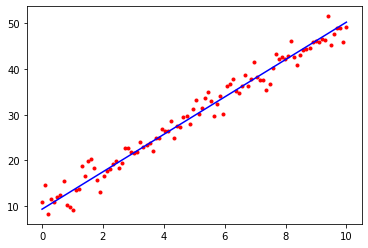

In [0]:
# Plot the training data again, together with the line defined by y = wx + b
# where w and b are our final learned parameters
plt.plot(x, t, 'r.')
plt.plot([0, 10], [params['b'], params['w'] * 10 + params['b']], 'b-')

## Linear Regression with a Feature Mapping

In this example we will fit a polynomial using linear regression with a polynomial feature mapping.
The target function is:

$$
t = x^4 - 10 x^2 + 10 x + \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, 4)$. 

This is an example of a _generalized linear model_, in which we perform a fixed nonlinear transformation of the inputs $\mathbf{x} = (x_1, x_2, \dots, x_D)$, and the model is still linear in the _parameters_. We can define a set of _feature mappings_ (also called feature functions or basis functions) $\phi$ to implement the fixed transformations.

In this case, we have $x \in \mathbb{R}$, and we define the feature mapping:
$$
\mathbf{\phi}(x) = \begin{pmatrix}\phi_1(x) \\ \phi_2(x) \\ \phi_3(x) \\ \phi_4(x) \end{pmatrix} = \begin{pmatrix}1\\x\\x^2\\x^3\end{pmatrix}
$$

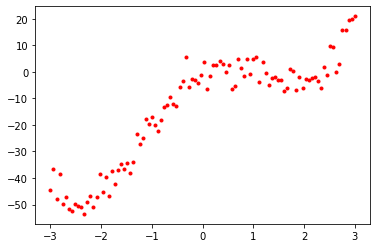

In [0]:
# Generate synthetic data
N = 100 # Number of data points
x = np.linspace(-3, 3, N) # Generate N values linearly-spaced between -3 and 3
t = x ** 4 - 10 * x ** 2 + 10 * x + npr.normal(0, 4, x.shape[0]) # Generate corresponding targets
plt.plot(x, t, 'r.') # Plot data points

t = torch.from_numpy(t).view(-1, 1)

In [0]:
M = 4 # Degree of polynomial to fit to the data (this is a hyperparameter)
feature_matrix = np.array([[item ** i for i in range(M+1)] for item in x]) # Construct a feature matrix 
feature_matrix = torch.from_numpy(feature_matrix).float()

w = torch.nn.Parameter(torch.randn(feature_matrix.shape[-1], 1))
print(w.shape)

def cost():
    y = torch.mm(feature_matrix, w)
    return (1.0 / N) * torch.sum(0.5 * (y - t)**2)

# Compute the gradient of the cost function using Autograd


num_epochs = 1000
learning_rate = 0.001

# Manually implement gradient descent
for i in range(num_epochs):
  loss = cost()
  loss.backward()
  print('loss:', loss.item())
  with torch.no_grad():
    w.data = w - learning_rate * w.grad
    w.grad.zero_()


# Print the final learned parameters.
print(w)
w = w.detach().cpu().numpy()

torch.Size([5, 1])
loss: 472.4221742639479
loss: 152.2463276293331
loss: 136.9154740323588
loss: 133.78703357596578
loss: 131.59982490233335
loss: 129.82386945283793
loss: 128.3590882734102
loss: 127.13880821175869
loss: 126.11105022892552
loss: 125.2349282691962
loss: 124.47831639097512
loss: 123.81591572770598
loss: 123.22783454112954
loss: 122.69843279933957
loss: 122.21540652163065
loss: 121.76906137476972
loss: 121.35180240060124
loss: 120.95763023019487
loss: 120.58182451073323
loss: 120.22068539146143
loss: 119.87129615046938
loss: 119.53135969523458
loss: 119.19907896316094
loss: 118.8730218406355
loss: 118.55207347697315
loss: 118.23534713373569
loss: 117.92216422818747
loss: 117.61196831240274
loss: 117.30432540776864
loss: 116.9989078322227
loss: 116.69543756066298
loss: 116.39371316207904
loss: 116.09356253763026
loss: 115.7948536108916
loss: 115.49748254014732
loss: 115.20136580210426
loss: 114.90644272653641
loss: 114.61265068354066
loss: 114.31996048716529
loss: 114.0283

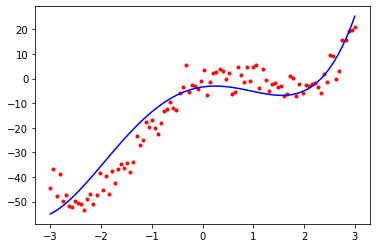

In [0]:
# Plot the original training data again, together with the polynomial we fit
plt.plot(x, t, 'r.')
plt.plot(x, np.dot(feature_matrix, w), 'b-')

## Neural Net Regression

In this example we will implement a (nonlinear) regression model using a neural network. To implement and train a neural net using Autograd, you only have to define the forward pass of the network and the loss function you wish to use; you do _not_ need to implement the _backward pass_ of the network. When you take the gradient of the loss function using `grad`, Autograd automatically computes computes the backward pass. It essentially executes the backpropagation algorithm implicitly.

![Neural Network Architecture for Regression](https://drive.google.com/uc?export=view&id=1iBNS40V_afm_Y1MUosDqeio0wbxgycfh)

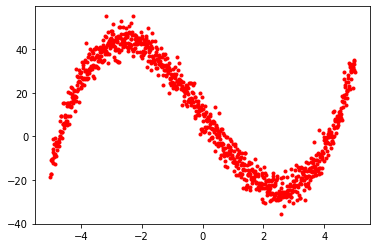

In [0]:
# Generate synthetic data
x = np.linspace(-5, 5, 1000)
t = x ** 3 - 20 * x + 10 + npr.normal(0, 4, x.shape[0])
plt.plot(x, t, 'r.')

x = torch.from_numpy(x).float()
t = torch.from_numpy(t)

tensor(326.8536, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(326.8536, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(326.7687, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(326.6078, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(326.3797, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(326.0924, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(325.7533, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(325.3693, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(324.9468, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(324.4913, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(324.0081, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(323.5016, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(322.9759, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(322.4344, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(321.8801, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(321.3157, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(3

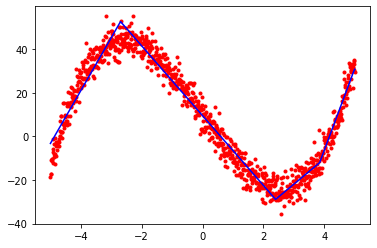

In [0]:
inputs = x.reshape(x.shape[-1],1)
W1 = torch.nn.Parameter(torch.randn(1,4))
b1 =  torch.nn.Parameter(torch.randn(4))
W2 =  torch.nn.Parameter(torch.randn(4,4))
b2 = torch.nn.Parameter(torch.randn(4))
W3 =  torch.nn.Parameter(torch.randn(4, 1))
b3 =  torch.nn.Parameter(torch.randn(1))

params = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3 }


#We can define an optimizer which takes care of updating parameters based on their gradient. We can use more complex optimizers like SGD+Momntum or Adam.
optimizer = torch.optim.SGD(params.values(), lr=0.0001, weight_decay=0.0001, momentum=0.9)

#Pytorch also has implementation of wide range of activation functions such as: Tanh, ReLU, LeakyReLU, ...
nonlinearity = torch.nn.ReLU()

def predict(params, inputs):
    h1 = nonlinearity(torch.mm(inputs, params['W1']) + params['b1'])
    h2 = nonlinearity(torch.mm(h1, params['W2']) + params['b2'])
    output = torch.mm(h2, params['W3']) + params['b3']
    return output

def cost(params):
    output = predict(params, inputs)
    return (1.0 / inputs.shape[0]) * torch.sum(0.5 * (output.reshape(output.shape[0]) - t)**2)

print(cost(params))

num_epochs = 10000

for i in range(num_epochs):
  # Evaluate the gradient of the current parameters stored in params
  loss = cost(params)
  print(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

with torch.no_grad():
  final_y = predict(params, inputs)
  plt.plot(x, t, 'r.')
  plt.plot(x, final_y, 'b-')

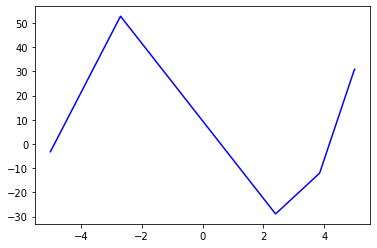

In [0]:
plt.plot(x, final_y, 'b-')

Unlike Tensorflow, we can define the graph on the fly. That is why it is more convenient to define a function in Python: we call the function as part of constructing the graph.

Let's now create a simple model for classifiying MNIST digits.

##MNIST Classification

MNIST is a famous dataset containing hand-written digits. The training set contains 60k and the test set contains 10k images. Pytorch has built-in functions for downloading well-known datasets like MNIST.

In [0]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('../data', train=False, download=True, transform=
                            transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27644958.33it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 438604.63it/s]
  1%|          | 16384/1648877 [00:00<00:11, 141285.89it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 7462473.12it/s]                           
8192it [00:00, 178869.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


  0%|          | 16384/9912422 [00:00<01:08, 143827.78it/s]

9920512it [00:00, 31655024.35it/s]                          


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 430081.37it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144230.78it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 7547969.20it/s]                            
8192it [00:00, 177445.91it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


Label:  7


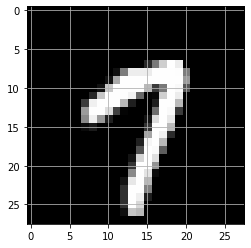

In [0]:
i = npr.randint(1, 50000) 
example = mnist_train[i]
print("Label: ", example[1])
plt.imshow(example[0].reshape((28,28)), cmap = plt.cm.gray)
plt.grid(None)

Pytorch's DataLoader is responsible for creating an iterator over the dataset.  

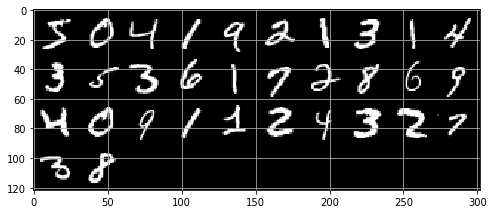

In [0]:
from torch.utils.data import DataLoader
import torchvision

mnist_train = datasets.MNIST('data', train=True, download=True,
                       transform=transforms.ToTensor())

mnist_test = datasets.MNIST('data', train=False, download=True, transform=
                            transforms.ToTensor())

bs = 32
train_dl = DataLoader(mnist_train, batch_size=bs)
test_dl = DataLoader(mnist_test, batch_size = 100)

dataiter = iter(train_dl)
images, labels = dataiter.next()
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (8,8))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.grid(None)

Using pytorch built-in function we can easily define any model like multi-layer perceptrons. After training, we just care about the average test accuracy, so let's write a function to compute the accuracy over test set.

In [0]:
def get_test_stat(model, dl, device):
    model.eval()
    cum_loss, cum_acc = 0.0, 0.0
    for i, (xb, yb) in enumerate(dl):
        xb = xb.to(device)
        yb = yb.to(device)
        
        xb = xb.view(xb.size(0), -1)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        acc = (torch.max(y_pred.data, 1)[1] == yb).sum() #accuracy(y_pred, yb)
        cum_loss += loss.item() * len(yb)
        cum_acc += acc.item() * len(yb)
    cum_loss /= 10000
    cum_acc /= 10000
    model.train()
    return cum_loss, cum_acc

In [0]:
dim_x = 784
dim_h = 100
dim_out = 10

model = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
)

learning_rate = 1e-2
epochs = 2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Using GPUs in PyTorch is pretty straightforward
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

#we need to tell pytorch to move the model to gpu
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    print(epoch)
    for i, (xb, yb) in enumerate(train_dl):

        #We also need to transfer the data to the target device
        xb = xb.to(device)
        yb = yb.to(device)
        xb = xb.view(xb.size(0), -1)
        
        # Forward pass
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)

        # Backward pass
        model.zero_grad()  # Zero out the previous gradient computation
        loss.backward()    # Compute the gradient
        optimizer.step()   # Use the gradient information to make a step
        
    test_loss, test_acc = get_test_stat(model, test_dl, device)
    print("Test loss: {}  Test acc: {}".format(test_loss, test_acc))


0
Test loss: 0.40868745774030685  Test acc: 88.95
1
Test loss: 0.32542646139860154  Test acc: 90.89


## Dynamic Network

To showcase the power of PyTorch dynamic graphs, we will implement a very strange model: a fully-connected ReLU network that on each forward pass randomly chooses a number between 1 and 4 and has that many hidden layers, reusing the same weights multiple times to compute the innermost hidden layers.

By Justin Johnson https://github.com/jcjohnson/pytorch-examples/blob/master/nn/dynamic_net.py

In [0]:
import random


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x, verbose = False):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.
        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.
        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        n_layers = random.randint(0, 3)
        if verbose:
            print("The number of layers for this run is", n_layers)
            # print(h_relu)
        for _ in range(n_layers):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
            if verbose:
                pass
                # print(h_relu)
        y_pred = self.output_linear(h_relu)
        return y_pred




# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10, 1

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = torch.randn(N, D_in)
y = torch.randn(N, D_out).requires_grad_(False)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(50):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.data.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 75.55640411376953
1 70.62905883789062
2 68.52175903320312
3 67.78900146484375
4 67.55087280273438
5 64.86112213134766
6 65.32463073730469
7 64.64488983154297
8 63.54672622680664
9 55.22225570678711
10 61.446903228759766
11 52.19249725341797
12 61.66746520996094
13 49.172584533691406
14 46.79412078857422
15 62.26521682739258
16 36.166812896728516
17 61.603309631347656
18 60.44231414794922
19 60.42289733886719
20 58.4093132019043
21 39.76520538330078
22 15.52701187133789
23 14.356389999389648
24 50.251373291015625
25 47.5118408203125
26 12.718317031860352
27 40.992271423339844
28 37.508750915527344
29 33.78058624267578
30 14.939048767089844
31 14.200834274291992
32 30.23629379272461
33 25.431053161621094
34 8.687077522277832
35 7.065875053405762
36 23.72148895263672
37 5.090020656585693
38 22.105833053588867
39 21.376110076904297
40 20.54547119140625
41 7.041802406311035
42 18.9364013671875
43 8.251858711242676
44 17.38003158569336
45 7.78367280960083
46 16.413854598999023
47 6.3910365

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


##Cifar10 Classification

We will finish with an example on CIFAR10, highlighting the importance of applying transformations to your inputs. Example is lifted from:

https://github.com/uoguelph-mlrg/Cutout/blob/master/train.py

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
def get_data(data_normalize=False, data_augment=False):
 
    train_transform = transforms.Compose([])
    test_transform = transforms.Compose([])

    if data_augment:
        train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
        train_transform.transforms.append(transforms.RandomHorizontalFlip())
    
    train_transform.transforms.append(transforms.ToTensor())
    test_transform.transforms.append(transforms.ToTensor())
        
    if data_normalize:
        normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                         std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
        train_transform.transforms.append(normalize)
        test_transform.transforms.append(normalize)

  
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=128,
                                               shuffle=True,
                                               num_workers=2)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=128,
                                              shuffle=False,
                                              num_workers=2)
    return train_loader, test_loader

def test(net, loader):
    net.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        with torch.no_grad():
            pred = net(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = correct / total
    net.train()
    return val_acc

In [0]:
def train_model(train_loader, test_loader, epochs=5):
    
    net = Net()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9) 
    criterion = nn.CrossEntropyLoss()
    train_accs = []
    test_accs = []
    
    net.train()

    for epoch in range(epochs):
        print(epoch)

        xentropy_loss_avg = 0.
        correct = 0.
        total = 0.

        for i, (images, labels) in enumerate(train_loader):
           
            net.zero_grad()
            pred = net(images)
            xentropy_loss = criterion(pred, labels)
            xentropy_loss.backward()
            optimizer.step()

            xentropy_loss_avg += xentropy_loss.item()

            # Calculate running average of accuracy
            pred = torch.max(pred.data, 1)[1]
            total += labels.size(0)
            correct += (pred == labels.data).sum().item()
            accuracy = correct / total
        
        test_acc = test(net, test_loader)
        print("Test acc: ", test_acc)
        train_accs.append(accuracy)
        test_accs.append(test_acc)
    return train_accs, test_accs

In [0]:
train_loader, test_loader = get_data(data_augment=False, data_normalize=False)
train_accs, test_accs = train_model(train_loader, test_loader, epochs=3)

0it [00:00, ?it/s]

170500096it [00:02, 73630492.24it/s]                               


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
0
Test acc:  0.2835
1
Test acc:  0.3006
2
Test acc:  0.3557


In [0]:
train_loader, test_loader = get_data(data_augment=False, data_normalize=True)
normalize_train_accs, normalize_test_accs = train_model(train_loader, test_loader, epochs=3)

Files already downloaded and verified
Files already downloaded and verified
0
Test acc:  0.3884
1
Test acc:  0.4332
2
Test acc:  0.4502


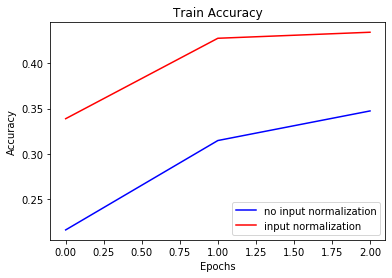

In [0]:
fig, ax = plt.subplots()
epochs = 3
ax.plot(range(epochs), train_accs, c="blue", label="no input normalization")
ax.plot(range(epochs), normalize_train_accs, c="red", label="input normalization")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Train Accuracy")
fig.show()